Collaborative Filtering is a common approach to developing recommendation engines.  Essentially it is an algorithm that relies on user behavior to provide a recommendation.  For further detail please visit https://www.analyticsvidhya.com/blog/2015/10/recommendation-engines/. 

In this post we will generate user purchase data and utilize the scikit Suprise library to implement a recommendation engine to identify cross selling opportunities.

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import math
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

%matplotlib inline

The data is a matrix of purchase history that contains 1,000 different users and 100 different products.  If the user owns the product then it will be represented as the number "1" else it will be represented as the number "0".   

Our goal is to have our algorithm recommend products that make sense to cross sell.  In order make sure our algorithm works, we've created a pattern in the data where the first 100 users only own products 0 thru 9 and the next 100 users own only products 10 thru 19, and so on.  There is only a 35% chance that the user will own the product to ensure we have cross selling opportunities.

The below heatmap you can see a visualization of the data. The rows are our 1,000 users and the columns are 100 products.  Each green dash is a product owned by that particular user.  Each square block is a cluster of products and users.  You could think of these clusters as being specific product division within a company.

If our algorithm is working correctly then it should only recommend cross selling opportunities within each user/product cluster.

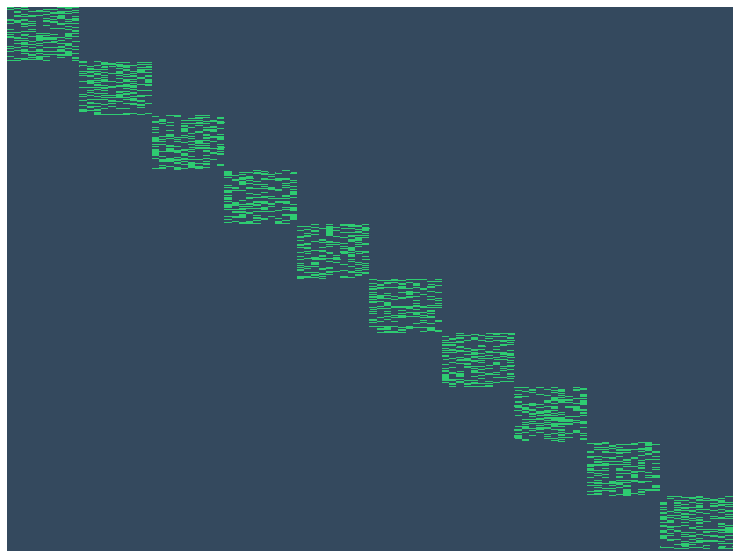

In [2]:
data = np.zeros((1000, 100))
purchases = np.random.choice(2, size=(1000, 10), p=[.65, .35])

for n in range(1000):
    # https://stackoverflow.com/questions/26454649/python-round-up-to-the-nearest-ten
    index = int(math.ceil((n+1) / 100.0)) * 10 
    data[n, index-10 : index] = purchases[n]
    
df = pd.DataFrame(data)

plt.figure(figsize=(13, 10))
sns.heatmap(df,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            cmap=sns.color_palette(["#34495e", "#2ecc71"]));

Of course with the data above you wouldn't need an algorithm to help you provide recommendations for cross selling but if we were to shuffle the rows and columns around a bit you will get a more sporadic looking dataset that visually looks random. However, the pattern we created still exists within the data even though it's shuffled.  This is where a recommendation algorithm can be useful as it will find any trends if they exists and provide us with useful recommendations.

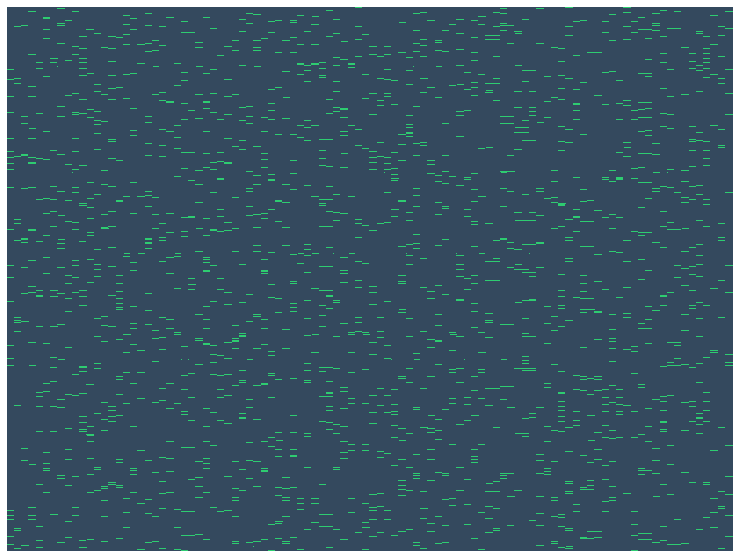

In [3]:
# https://stackoverflow.com/questions/47923429/how-to-shuffle-a-pandas-dataframe-randomly-by-row
df = df.sample(frac=1, axis=0).sample(frac=1, axis=1)

plt.figure(figsize=(13, 10))
sns.heatmap(df,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            cmap=sns.color_palette(["#34495e", "#2ecc71"]));

The algorithm we are using requires the data be in a transactional format where each row represents the user, the product, and whether or not the product is purchased (1 = purchased, 0 = not purchased).

To better distinguish users from products we'll prefix the user_id with 'u_' and the product_id with 'p_'.  This will be useful in understanding the outputs from our algorithm as it can also similar users if we desire.  

Below is the first 10 rows in our data.

In [4]:
# https://stackoverflow.com/questions/26639003/python-unpivot-data

df = pd.melt(df.reset_index(), id_vars=['index'])
df = df.sample(frac=1, axis=0).reset_index(drop=True)
df.columns = ['user_id', 'product_id', 'is_purchase']
df.user_id = df.user_id.map(lambda x: f'u_{x}')
df.product_id = df.product_id.map(lambda x: f'p_{x}')

df.head(10)

,user_id,product_id,is_purchase
0,u_913,p_99,0.0
1,u_521,p_15,0.0
2,u_597,p_75,0.0
3,u_436,p_78,0.0
4,u_799,p_23,0.0
5,u_687,p_34,0.0
6,u_862,p_87,0.0
7,u_520,p_52,0.0
8,u_480,p_63,0.0
9,u_500,p_7,0.0


Now that our data is ready we can train/fit the algorithm.  The algorithm "KNNBasic" computes a similarity matrix between users and then uses that matrix to predict whether or not the user owns the product.  

We've created a function called "get_top_n" that by default uses our trained algorithm to make a prediction for every user and then returns the 10 products that had the highest probability of being owned by the user.

If our algorithm is working correctly it will recommended for users 0 - 99 products 0 - 9, for users 100 - 199 products 10 - 19 and so on.

In [5]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df, reader)
algo = KNNBasic(sim_options={'user_based': True})
trainset = data.build_full_trainset()
algo.fit(trainset)
testset = trainset.build_testset()
predictions = algo.test(testset)

def get_top_n(predictions, n=10):
    '''
    Return the top-N recommendation for each user from a set of predictions.
    
    Source: 
        https://surprise.readthedocs.io/en/stable/FAQ.html

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)
print('\n First 20 Results: \n')
count = 0
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    count += 1
    if count == 20:
        break

Computing the msd similarity matrix...
Done computing similarity matrix.

 First 20 Results: 

u_913 ['p_95', 'p_97', 'p_92', 'p_90', 'p_98', 'p_96', 'p_99', 'p_91', 'p_93', 'p_94']
u_521 ['p_52', 'p_55', 'p_51', 'p_50', 'p_53', 'p_58', 'p_57', 'p_54', 'p_47', 'p_90']
u_597 ['p_53', 'p_59', 'p_52', 'p_57', 'p_54', 'p_56', 'p_50', 'p_51', 'p_58', 'p_55']
u_436 ['p_44', 'p_41', 'p_43', 'p_45', 'p_47', 'p_48', 'p_40', 'p_42', 'p_49', 'p_46']
u_799 ['p_76', 'p_70', 'p_74', 'p_71', 'p_73', 'p_23', 'p_79', 'p_90', 'p_47', 'p_19']
u_687 ['p_61', 'p_60', 'p_63', 'p_64', 'p_66', 'p_69', 'p_68', 'p_62', 'p_65', 'p_67']
u_862 ['p_88', 'p_81', 'p_86', 'p_89', 'p_83', 'p_84', 'p_85', 'p_87', 'p_82', 'p_80']
u_520 ['p_50', 'p_57', 'p_56', 'p_51', 'p_55', 'p_52', 'p_59', 'p_68', 'p_84', 'p_2']
u_480 ['p_44', 'p_49', 'p_45', 'p_43', 'p_47', 'p_42', 'p_40', 'p_41', 'p_48', 'p_46']
u_500 ['p_58', 'p_55', 'p_57', 'p_56', 'p_52', 'p_54', 'p_50', 'p_51', 'p_53', 'p_59']
u_85 ['p_9', 'p_0', 'p_8', 'p_1', 'p

With the top 10 product recommendations for each user available to us, we can use it to generate Opportunities for specific users.

Below we iterate through the top recommendations for User 'u_9' and identify cross selling opportunities with the label "Opportunity:".

In [6]:
for item in top_n['u_9']:
    if item[0] in df[(df.user_id =='u_9') & (df.is_purchase==1)].product_id.to_list():
        print(f'Purchased: {item[0]}')
    else:
        print(f'Opporutnity: {item[0]}')

Purchased: p_9
Purchased: p_4
Purchased: p_1
Opporutnity: p_2
Opporutnity: p_7
Opporutnity: p_3
Opporutnity: p_8
Opporutnity: p_0
Opporutnity: p_5
Opporutnity: p_6


Because our algorithm computes a similarity matrix we can leverage it to find the **n** nearest neighbors for any user.  This can be leveraged for other tasks such as pricing guidance or would could just retrain our algorithm to predict pricing instead of purchases and use those prediction as pricing recommendations.

Below we show the 25 nearest neighbors to user "u_1".  If it is working correctly we should see mostly 25 users within the range of users 0 - 99.

In [7]:
neighbors = algo.get_neighbors(trainset.to_inner_uid('u_1'), k=25)

print("25 most similar Users to 'u_1': \n")
print([trainset.to_raw_uid(user) for user in neighbors])

25 most similar Users to 'u_1': 

['u_30', 'u_73', 'u_23', 'u_76', 'u_51', 'u_86', 'u_36', 'u_78', 'u_35', 'u_68', 'u_26', 'u_63', 'u_11', 'u_2', 'u_32', 'u_85', 'u_31', 'u_54', 'u_67', 'u_61', 'u_7', 'u_45', 'u_21', 'u_66', 'u_25']


Since were using "user based similarities" to provide recommendations we can't provide recommendations for new user.  This is termed the "cold start problem".

Instead we can train a separate algorithm that uses "item based similarities" to recommend products that are similar to one another.  For example if our new user is interested in product 25 "p_25" our algorithm should be able to recommend products 20 thru 29 as cross selling opportunities. 



In [8]:
algo = KNNBasic(sim_options={'user_based': False})
algo.fit(trainset)
neighbors = algo.get_neighbors(trainset.to_inner_iid('p_25'), k=9)
print("\n 9 most similar Products to p_25: \n")
print([trainset.to_raw_iid(item) for item in neighbors])

Computing the msd similarity matrix...
Done computing similarity matrix.

 9 most similar Products to p_25: 

['p_21', 'p_29', 'p_28', 'p_22', 'p_26', 'p_27', 'p_23', 'p_24', 'p_20']


## Resources:

* http://surpriselib.com/
* https://www.analyticsvidhya.com/blog/2015/10/recommendation-engines/
* https://www.datacamp.com/community/tutorials/recommender-systems-python
* https://realpython.com/build-recommendation-engine-collaborative-filtering/